# How do we evaluate?

Having looked at annotation and some baseline approaches for the estimation
of beat and tempo from music signals, let's turn our attention towards
evaluation. 

So, why do we conduct evaluation? Among other things we might want to:

* Know the performance of our algorithm.
* Compare it against other algorithms.
* Understand its strengths and weakness towards improving it.

In some sense we've been doing a kind of implicit evaluation already by listening
to the output of beat estimates mixed back with the input musical audio signal,
albeit not in a quantitative way. 

Likewise, performing annotation is accompanied by a kind of constant evaluation 
(i.e., "accuracy-maximizing") process which assesses the choice of metrical level, 
the phase of the beats, and their temporal localisation.  

Indeed, there is nothing wrong *at all* with doing evaluation this way and 
in line with our understanding of the beat as a perceptual construct, this 
is our baseline position... essentially "*does it sound right when I hear it played back?*"

However, the design and execution of large scale evaluation of beat (or downbeat)
tracking algorithms where rating scales are used to grade performance 
is time-consuming and expensive (it requires real-time listening possibly multiple times).
It is also difficult to repeat in an exact way and to determine 
a set of unambiguous judging criteria. Note, since most people
only have "relative" rather than "perfect tempo" it's rather hard to 
design an subjective experiment for absolute tempo perception
without the instantion of the tempo in terms of beats. 

Within the beat tracking literature, more effort has been devoted to the use 
of objective evaluation methods which relate a sequence of beat annotations
(the so-called "ground truth") with a sequence of estimates from an algorithm (or a tapper),
as shown in the figure below. In the ideal, we're looking for some 
number (or set of numbers) that we can calculate by comparing
the two temporal sequences in such a way as to reflect the general consensus
of human listeners. So, if the beats are perceptually acceptable, our objective
evaluation method should give us a high score, and vice-versa.

Whether that goal is realisable or not is certainly debatable 
(we could even have that debate in the discussion part of the tutorial!)
but for now, let's explore a few (of the many) existing objective approaches.
For a more detailed list see {cite}`davies2009evaluation`.

Following the approach in the previous parts of the basics section, 
we'll try avoid notation as much possible (*don't worry there's plenty of notation
coming in the later sections!*) and instead rely on intuition and observation
to guide us.

```{figure} ../assets/ch2_basics/figs/objective_v_subjective.png
---
alt: Objective vs Subjective
width: 600px
align: center
name: eval_objective_v_subjective
---
Overview of objective methods vs subjective ratings
```



## F-measure

Among the most used evaluation methods is the F-measure, which is also widely adopted
in onset detection, structural boundary detection and other 
temporal MIR tasks. A high-level graphical overview is shown below.

```{figure} ../assets/ch2_basics/figs/fmeasure.png
---
alt: F-measure
width: 600px
align: center
name: eval_fmeasure
---
F-measure
```

For beat tracking, we typically use a tolerance window of +/- 70ms around 
each ground truth annotation. 
* Beats that uniquely fall into these tolerance windows are **true positives** (or **hits**).
* Any additional beats in each tolerance window, or those outside of any tolerance window,
counted as **false positives**. 
* Finally, any empty tolerance windows with no beats are counted as **false negatives**.

With these three quantities we can calculate the **precision**
and **recall** and in turn the F-measure.

However, if we choose the vary the size of the tolerance
window we can dramatically change these quantities.
Make it too wide, and we'll treat very poorly localised
beats as accurate, and by contrast too narrow, and we'll mark
perceptually accurate beats as errors.

```{figure} ../assets/ch2_basics/figs/tol.gif
---
alt: F-measure anim
width: 450px
align: center
name: eval_fmeasure_anim
---
Animation of F-measure tolerance window
```

The implication of using a fixed tolerance window is that
whenever the beats are uniquely inside and regardless
of their temopral location to the annotation, they're considered accurate.
We can push this to a somewhat absurd extreme, by 
anticipating the even beat annotations by just under 70ms
and offseting the odd beat annotations by the same amount.



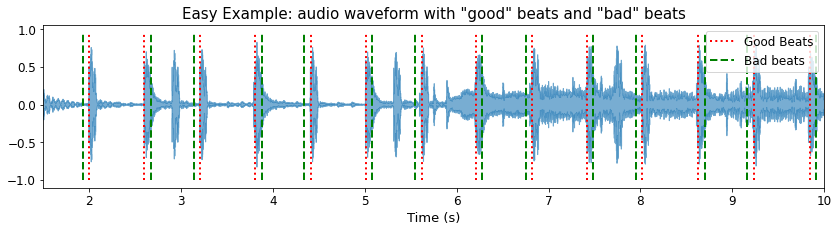

In [3]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import mir_eval
import matplotlib.pyplot as plt
import scipy.stats


filename = '../assets/ch2_basics/audio/easy_example'

sr = 44100
FIGSIZE = (14,3)

# read audio and annotations
y, sr = librosa.load(filename+'.flac', sr = sr)
ref_beats = np.loadtxt(filename+'.beats')
ref_beats = ref_beats[:,0]
bad_beats = ref_beats.copy()
bad_beats[::2] = bad_beats[::2]-0.069
bad_beats[1::2] = bad_beats[1::2]+0.069

y_good_beats = librosa.clicks(times=ref_beats, sr=sr, click_freq=1000.0, 
                              click_duration=0.1, length=len(y))

y_bad_beats = librosa.clicks(times=bad_beats, sr=sr, click_freq=1000.0, 
                              click_duration=0.1, length=len(y))

plt.figure(figsize=FIGSIZE)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.vlines(ref_beats, 1.1*y.min(), 1.1*y.max(), label='Good Beats', color='r', linestyle=':', linewidth=2)
plt.vlines(bad_beats, 1.1*y.min(), 1.1*y.max(), label='Bad beats', color='green', linestyle='--', linewidth=2)

plt.legend(fontsize=12); 
plt.title('Easy Example: audio waveform with "good" beats and "bad" beats', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time (s)', fontsize=13)
plt.legend(fontsize=12); 
plt.xlim(1.5, 10);

Let's listen first the unmodified beat annotations.

In [4]:
ipd.Audio(0.6*y[1*sr:10*sr]+0.25*y_good_beats[1*sr:10*sr], rate=sr)

and then the limit of accurate F-measure

In [5]:
ipd.Audio(0.6*y[1*sr:10*sr]+0.25*y_bad_beats[1*sr:10*sr], rate=sr)

We can confirm the F-measure score using `mir_eval`

In [6]:
print('Fmeasure:', round(mir_eval.beat.f_measure(ref_beats, bad_beats), 3))

Fmeasure: 1.0


Of course, this is a deliberately bad output practically at the limit
of what the F-measure calculation will allow, and it's
probably better not to dwell too much on cases like this, but 
rather accept that this seemingly big tolerance window
is useful to catch either: i) natural human variation in tapping
and not punish it, or ii) contend with cases like arpeggiated chords
(e.g., the first annotated beat in our expressive example)
where it's difficult to mark a single beat location. 

## Cemgil

An alternative to using a "top-hat" tolerance window is instead to use a Gaussian distribution 
placed around each annotation. Here we no longer have the notion of a true or false positive,
but rather each beat can be assigned the value corresponding to the value of the Gaussian located
at the nearest annotation.

In this way, poor localisation like in the "bad beats" example
would be punished since the value of the Gaussian (with standard deviation 40ms as in 
the original paper and `mir_eval` and `madmom` implementations) 
at an offset of +/-70ms will be rather low. 


```{figure} ../assets/ch2_basics/figs/cemgil.png
---
alt: Cemgil
width: 600px
align: center
name: eval_cemgil
---
Cemgil evaluation approach
```


We can verify this with `mir_eval` 

In [7]:
print('Cemgil:', round(mir_eval.beat.cemgil(ref_beats, bad_beats)[0], 3))

Fmeasure: 0.226


And thus we have an F-measure of 1.00 but a Cemgil accuracy of 0.226.

So, how can we use that information to our advantage?

Via the **combination** of these two scores we can begin to make some interpretation about
the qualitative nature of the relationship between estimated beats
and annotations. Which in this case would tell us that 
the metrical level and phase of the beat estimates are 
the same as the ground truth annotations, but they
are poorly localised. 

```{note}

Thus far, we've looked at two different, but related, approaches
to the evaluation of temporal sequences. 
We've seen too that the F-measure score can be kind of "gamed."
There's a couple of worthwhile additional perspectives to consider.

1. Both of these approaches make what we could understand as **time-indendent** measurements
of beat tracking accuracy. Which is to say that each estimated beat is 
treated as an isolated point in time. So, we have no notion of 
a beat interval to work with in evaluation. This is largely
fine for onset detection and structural boundary detection,
but somewhat sub-optimal for temporal data with some strong
periodic organisation like musical beats.

2. What does it mean to score and F-measure or Cemgil accuracy of 0.00? 
It almost certainly does not mean that there is a totally random
relationship between the estimated beats and ground truth annotation,
but much more likely that the estimated beats are tapped on the "off-beat"
to the annotations. 
````




## Continuity-based

With the two points in the above note in mind, we can 
explore the properties of the "Continuty-based" evaluation approach.
Here we make two principal changes: 

* The first is that 
we only consider beat *i* to be accurate if it falls within the tolerance
window (*more on how that's defined in a moment*) and 
that beat *i-1* also falls within its respective tolerance window, 
as shown in figure below. Note, in addition we require
that the inter-beat-interval also be consistent
with the inter-annotation-intereval. 

```{figure} ../assets/ch2_basics/figs/continuity1.png
---
alt: Continuity overview
width: 600px
align: center
name: eval_continuity1
---
Overview of contuity based approach
```

* Secondly, and to try to account for some metrical ambiguity in 
what might be an acceptable sequence of beat estimates,
we can generate multiple metrical variations of the annotations
and evaluate against each of these in turn, picking the best
score available. These metrical variations typically constitute
    * The same metrical level and "in-phase"
    * The same metrical level, but tapped on the "off-beat"
    * Twice the annotated metrical level
    * Half the annotated metrical level (taking every other annotated beat and starting on the **first**)
    * Half the annotated metrical level (taking every other annotated beat and starting on the **second**)

Depending on the implementation, there may be scope
to allow for a **triple** and **1/3rd** variation as well,
e.g., the evaluation routines in `madmom` allow for this possibility. 
    
```{note}
This set of allowed metrical levels bears some similarity
to increasing the size of the tolerance window for the
F-measure. The more different metrical variations we allow
the greater the chance that our beat tracker will hit
one of these, even though some might be rather unlikely
for a given piece of music. 
```
    
In the figure below, we demonstrate what happens if the
beat estimates are tapped at twice the tempo of the
annotations. If we look for continuity between the 
estimated beat and annotations, we won't get it,
nor at any of the other possibilities except "double" variation.

This means, if we force consistency over the choice of metrical level 
we'd score precisely 0, but if we take the maximum over these 
five variations, we could obtain an accuracy of 1.

```{figure} ../assets/ch2_basics/figs/continuity_levels.png
---
alt: Continuity levels
width: 600px
align: center
name: eval_cont_levels
---
Example alternative metrical levels for continuity-based evaluation
```

**But what's going on with those tolerance windows?**

Those with keen observation skills will have noticed that
the choice of metrical variation has an impact on the width
of the tolerance window. As we move to faster metrical
levels, the tolerance window shrinks, and as we move
to slower metrical levels it gets wider.

This is because the tolerance windows for the continuity-based
approach, rather than being calculated in **absolute** time
as in the F-measure (or indeed the parameterisation of the Gaussian
for Cemgil's approach) they are calculated in a **beat-relative**
manner, and set to 17.5% of each inter-annotation-interval. 

Finally (*yes, we're still talking about evaluation!*) even
with all of these factors, we still have two ways in which
we can extract an accuracy score. 

* First, whether we want to take the ratio of the longest continuously
correct segment to the length of the excerpt (the "c" variation of CMLc, AMLc)
* Or, if we want to take the ratio of the total of the continuously
correct segments to the length of the excerpt (the "t" variation of CMLt, AMLt).

So, after all that, we have: 
* CMLc: "correct" (i.e., annotated) metrical level, with longest single continous segment.  
* CMLt: "correct" (i.e., annotated) metrical level, with the total of continous segments.
* AMLc: "allowed" metrical levels, with longest single continous segment.  
* AMLt: "allowed" metrical levels, with the total of continous segments. 

Based on these scores, we can determine the following:
* CMLc <= CMLt and likewise AMLc <= AMLt
* CMLc <= AMLc and likewise CMLt <= AMLt

and by virtue of these
* CMLc <= AMLt

but 
* CMLt is not guaranteed to be less than AMLc!

For completeness, let's return to our "bad beats"
and check the scores under the continuity approaches:

In [14]:
print({m:v for m,v in zip(['CMLc', 'CMLt', 'AMLc', 'AMLt'], 
                                            mir_eval.beat.continuity(ref_beats, bad_beats))})


{'CMLc': 0.0, 'CMLt': 0.0, 'AMLc': 0.0, 'AMLt': 0.0}


So, 0.0 all round! Since the AMLx scores are zero, we know the CMLx ones must be too. 
But, we only shifted the bad beats around by just under 70ms, and technically this
would be okay according to the +/- 17.5% tolerance windows for phase accuracy. 
Where this fails is in the periodicity criteria, which is that the 
inter-beat-intervals alternate between being greater than and less than
the allowed inter-annotation-interval. 

## Beat Evaluation Perspectives

So, after our quick overview of some (but not all) of the available evaluation methods, the question is which should you use? ... It depends!

* If we know that our algorithm scores highly on CMLc, then we know quite a lot about what that means.  
    * Our algorithm has picked the same metrical level as the one that has been annotated, so we circumvent the chance that the metrical level our beat tracker has picked is "allowed" under the rules, but not appropriate for the individual piece.
    * We also know that our beat estimates were pretty consistently well-aligned with ground truth annotations.
    * In situations where CMLt >> CMLc, this can tell us that we've got an odd mis-placed beat somewhere and thus we were right most of the time but lapsed just for a moment.
    * It's important to stress that this might not be an "error" at all, but an isolated bad annotation in need of correction. 
    * But, ultimately, if we have high confidence in our annotations, then we can do a lot worse than trying to maximise CMLc. 

* While it's possible to report a single or set of accuracy scores to summarise the performance of an algorithm, e.g., algorithm X has a mean accuracy of 1000 files = 0.87. We can learn more about its behaviour by:
    * Plotting its performance over a range of thresholds (i.e., tolerance window sizes) 
    * Looking at visualisations of the relationship between the annotations and the estimated beats so we can pinpoint and understand errors.
        
On this final point, it may be of interest to look at a very recent approach to evaluation ({cite}`pinto2021user` and its open-source implementation [here](https://github.com/MR-T77/ShiftIfYouCan)) which determines and visualises the set of steps necessary to transform a beat sequence in such a way that it would maximise the F-measure. In some sense, it tries to replicate and measure the kind of annotation corrections we've seen previously in the annotation section. 
    
  

## Extending to tempo and downbeats

The vast majority of this section has looked at issues related to beat tracking evaluation. 
Indeed, the extension to downbeat estimation is quite straightforward, and 
frequently the F-measure and Continuity-based evaluation methods are used. 

For tempo estimation, it has been commonplace to report two scores: "Acc1" and "Acc2"
which verify if an estimated tempo is within +/- 4% of the annotated tempo
for Acc1 and likewise for Acc2, but allowing for "octave errors" in the 
similar way to the "allowed" metrical levels of AMLc/AMLt.
However, the recent work of Schreiber et al {cite}`schreiber20tismir` and the
[tempo_eval](https://tempoeval.github.io/tempo_eval/) resource have suceeded
in moving forward the topic of global tempo evaluation.
